In [4]:
%matplotlib inline
import os
import glob
import dateutil
import datetime
import warnings
import traceback

from multiprocessing import Pool

import tqdm
import dask
import dask.bag as db
import pyart
import netCDF4
# import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

from dask.diagnostics import ProgressBar

warnings.simplefilter('ignore')

In [18]:
# flist = sorted(glob.glob('/g/data2/rr5/CPOL_radar/CPOL_level_1a/2013/2013010*/*.nc'))
flist = sorted(glob.glob('/g/data2/rr5/CPOL_radar/CPOL_level_1a/2006/2006010*/*.nc'))

In [19]:
def read_netcdf(infile):    
    try:
        with netCDF4.Dataset(infile) as ncid:
            r = ncid['range'][:]
            sl = slice(ncid['sweep_start_ray_index'][0], ncid['sweep_end_ray_index'][1])
            azi = ncid['azimuth'][sl]
            dbz = ncid['DBZ'][sl] # .filled(np.NaN)
    except Exception:
        return None
        
    return r, azi, dbz

In [20]:
bag = db.from_sequence(flist)
bagobj = bag.map(read_netcdf)
with ProgressBar():
    rslt = bagobj.compute()

[########################################] | 100% Completed | 26.4s


In [7]:
# with Pool(16) as pool:
#     rslt = list(tqdm.tqdm_notebook(pool.imap(read_netcdf, flist), total=len(flist)))

In [21]:
skip = [e for e in range(len(rslt)) if rslt[e] is None]

In [22]:
[rslt.pop(s) for s in skip[::-1]]

[]

In [23]:
myshape = [dbz[:, r<10e3].shape for r, azi, dbz in rslt]

In [25]:
import collections

In [26]:
collections.Counter(myshape)

Counter({(488, 33): 75,
         (489, 33): 25,
         (487, 33): 299,
         (486, 33): 144,
         (485, 33): 484,
         (484, 33): 47,
         (483, 33): 211,
         (481, 33): 3,
         (482, 33): 4})

In [28]:
# skip = []
# for cnt, ms in enumerate(myshape):
#     if ms != (485, 33):
#         skip.append(cnt)
#         print(cnt, ms)
        
# [rslt.pop(s) for s in skip[::-1]]

In [13]:
# megarefl = np.zeros((len(rslt), 719, 36))
# for cnt, (r, azi, dbz) in enumerate(rslt):
#     megarefl[cnt, :, :] = dbz[:, r<10e3]

In [29]:
megarefl_2006 = np.zeros((len(rslt), 485, 33))
for cnt, (r, azi, dbz) in enumerate(rslt):
    megarefl_2006[cnt, :, :] = dbz[:, r<10e3]

In [35]:
reflmax_2006 = np.nanpercentile(megarefl_2006, 95, axis=0)

In [14]:
# reflmax = np.nanpercentile(megarefl, 99, axis=0)
# refl95 = np.nanpercentile(megarefl, 95, axis=0)
# reflstd = np.nanstd(megarefl, axis=0)
# reflmean = np.nanmean(megarefl, axis=0)

In [15]:
# R, A = np.meshgrid(r[r < 10e3], azi)

# theta = 450 - A
# theta[theta > 360] -= 360
# x = R * np.cos(np.pi * theta / 180)
# y = R * np.sin(np.pi * theta / 180)

In [31]:
R, A = np.meshgrid(r[r < 10e3], azi)

theta = 450 - A
theta[theta > 360] -= 360
x_2006 = R * np.cos(np.pi * theta / 180)
y_2006 = R * np.sin(np.pi * theta / 180)

In [32]:
# freq = 100 * np.sum(~np.isnan(megarefl), axis=0) / len(rslt)
freq_2006 = 100 * np.sum(~np.isnan(megarefl_2006), axis=0) / len(rslt)

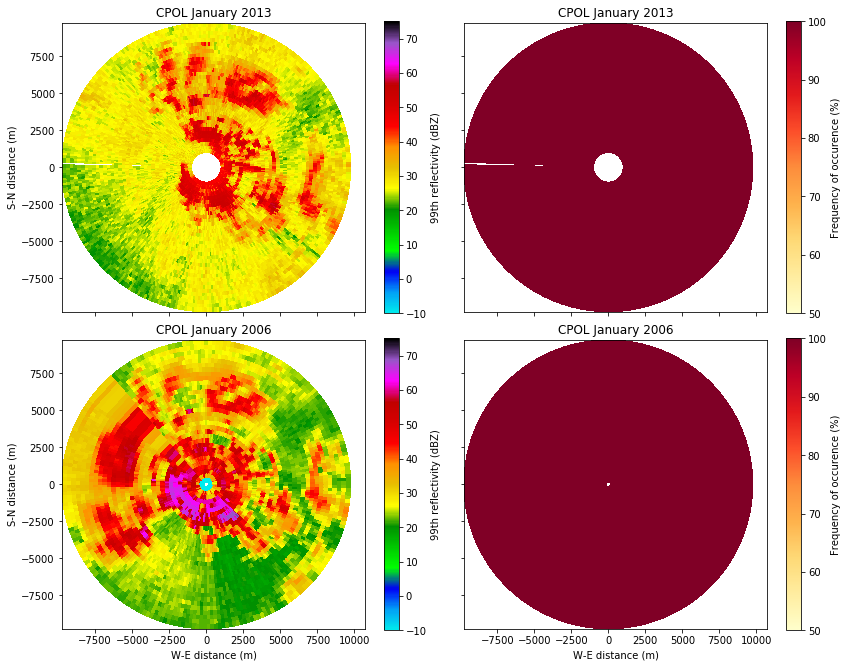

In [36]:
cax = [None] * 4
txt = ['99th reflectivity (dBZ)', 'Frequency of occurence (%)', '99th reflectivity (dBZ)', 'Frequency of occurence (%)']
fig, ax = pl.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

cax[0] = ax[0].pcolormesh(x[:360, :], y[:360, :], reflmax[:360, :], cmap='pyart_NWSRef', vmin=-10, vmax=75)
ax[0].set_title('CPOL January 2013')
cax[1] = ax[1].pcolormesh(x[:360, :], y[:360, :], freq[:360, :], cmap='YlOrRd', vmin=50, vmax=100)
ax[1].set_title('CPOL January 2013')

cax[2] = ax[2].pcolormesh(x_2006[:360, :], y_2006[:360, :], reflmax_2006[:360, :], cmap='pyart_NWSRef', vmin=-10, vmax=75)
ax[2].set_title('CPOL January 2006')
cax[3] = ax[3].pcolormesh(x_2006[:360, :], y_2006[:360, :], freq_2006[:360, :], cmap='YlOrRd', vmin=50, vmax=100)
ax[3].set_title('CPOL January 2006')

ax[0].set_ylabel('S-N distance (m)')
ax[2].set_ylabel('S-N distance (m)')
ax[2].set_xlabel('W-E distance (m)')
ax[3].set_xlabel('W-E distance (m)')

for myax, mycax, mytxt in zip(ax, cax, txt):
    cbar = pl.colorbar(mycax, ax=myax)
    cbar.set_label(mytxt)
    myax.set_aspect(1)

# fig.suptitle(f'CPOL - January 2013 ({len(rslt)} files)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
pl.show()

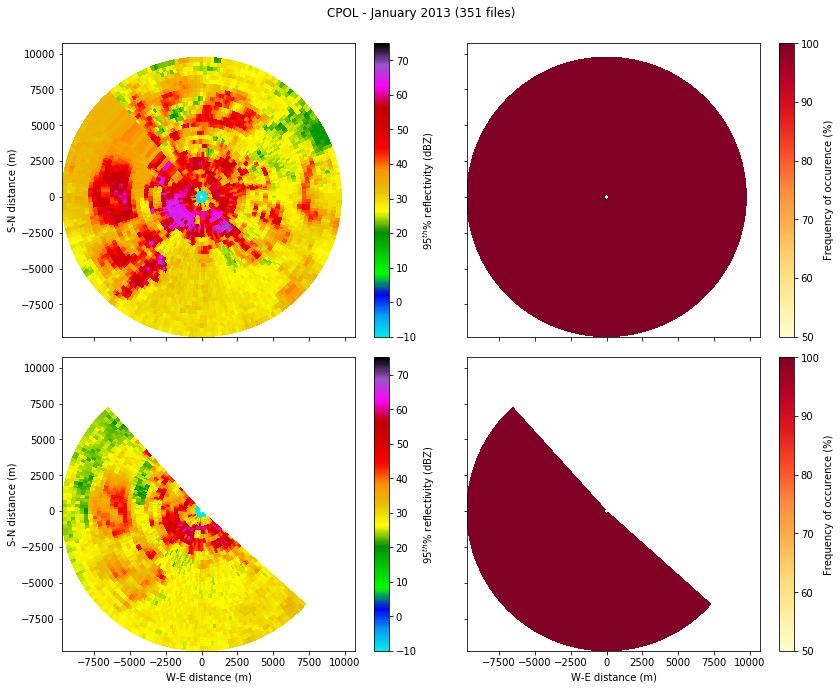

In [21]:
cax = [None] * 4
txt = ['$95^{th} \%$ reflectivity (dBZ)', 'Frequency of occurence (%)', '$95^{th} \%$ reflectivity (dBZ)', 'Frequency of occurence (%)']
fig, ax = pl.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

cax[0] = ax[0].pcolormesh(x[:360, :], y[:360, :], refl95[:360, :], cmap='pyart_NWSRef', vmin=-10, vmax=75)
cax[1] = ax[1].pcolormesh(x[:360, :], y[:360, :], freq[:360, :], cmap='YlOrRd', vmin=50, vmax=100)

cax[2] = ax[2].pcolormesh(x[360:, :], y[360:, :], refl95[360:, :], cmap='pyart_NWSRef', vmin=-10, vmax=75)
cax[3] = ax[3].pcolormesh(x[360:, :], y[360:, :], freq[360:, :], cmap='YlOrRd', vmin=50, vmax=100)

ax[0].set_ylabel('S-N distance (m)')
ax[2].set_ylabel('S-N distance (m)')
ax[2].set_xlabel('W-E distance (m)')
ax[3].set_xlabel('W-E distance (m)')

for myax, mycax, mytxt in zip(ax, cax, txt):
    cbar = pl.colorbar(mycax, ax=myax)
    cbar.set_label(mytxt)
    myax.set_aspect(1)

fig.suptitle(f'CPOL - January 2013 ({len(rslt)} files)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
pl.show()

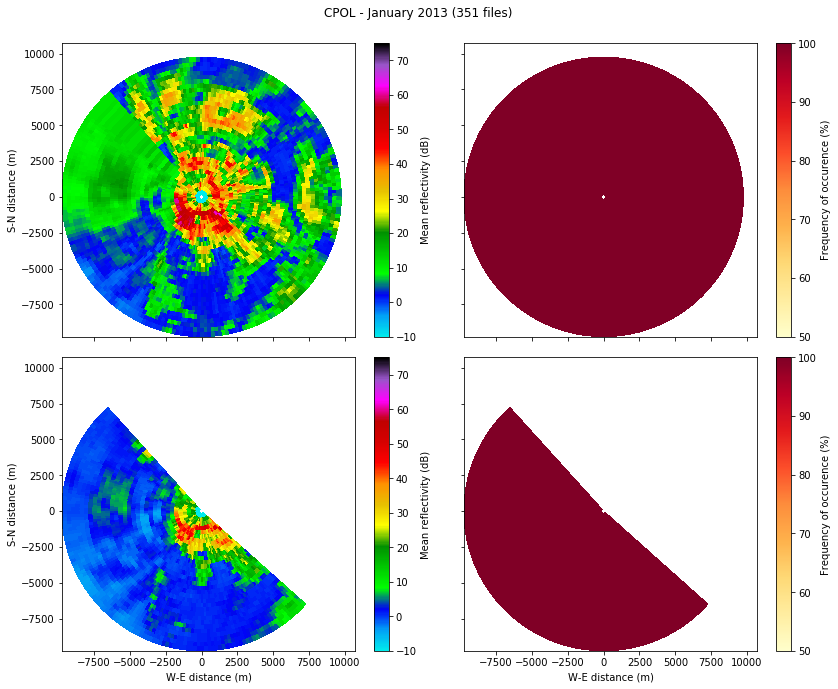

In [22]:
cax = [None] * 4
txt = ['Mean reflectivity (dB)', 'Frequency of occurence (%)', 'Mean reflectivity (dB)', 'Frequency of occurence (%)']
fig, ax = pl.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

cax[0] = ax[0].pcolormesh(x[:360, :], y[:360, :], reflmean[:360, :], cmap='pyart_NWSRef', vmin=-10, vmax=75)
cax[1] = ax[1].pcolormesh(x[:360, :], y[:360, :], freq[:360, :], cmap='YlOrRd', vmin=50, vmax=100)

cax[2] = ax[2].pcolormesh(x[360:, :], y[360:, :], reflmean[360:, :], cmap='pyart_NWSRef', vmin=-10, vmax=75)
cax[3] = ax[3].pcolormesh(x[360:, :], y[360:, :], freq[360:, :], cmap='YlOrRd', vmin=50, vmax=100)

ax[0].set_ylabel('S-N distance (m)')
ax[2].set_ylabel('S-N distance (m)')
ax[2].set_xlabel('W-E distance (m)')
ax[3].set_xlabel('W-E distance (m)')

for myax, mycax, mytxt in zip(ax, cax, txt):
    cbar = pl.colorbar(mycax, ax=myax)
    cbar.set_label(mytxt)
    myax.set_aspect(1)

fig.suptitle(f'CPOL - January 2013 ({len(rslt)} files)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
pl.show()

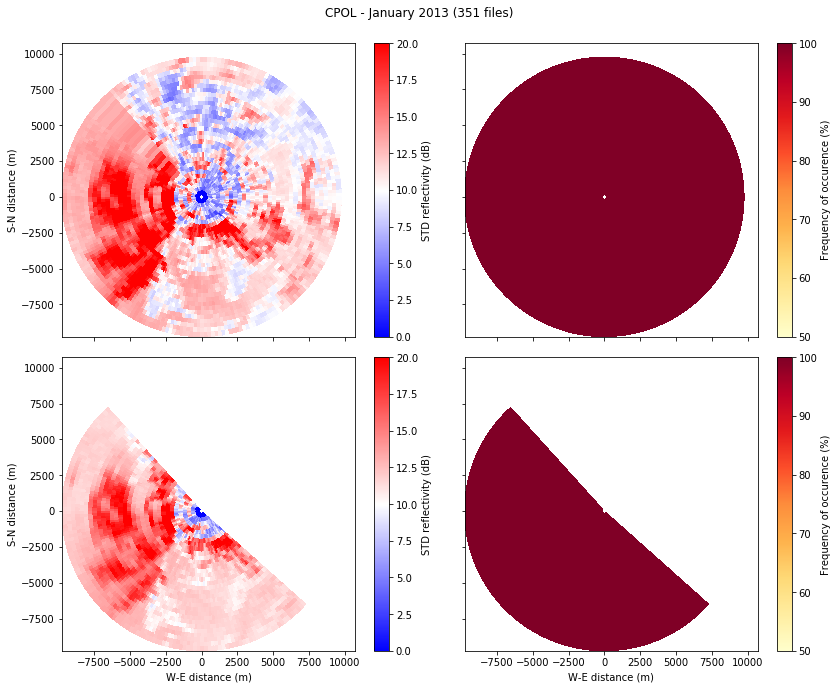

In [23]:
cax = [None] * 4
txt = ['STD reflectivity (dB)', 'Frequency of occurence (%)', 'STD reflectivity (dB)', 'Frequency of occurence (%)']
fig, ax = pl.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

cax[0] = ax[0].pcolormesh(x[:360, :], y[:360, :], reflstd[:360, :], cmap='bwr', vmin=0, vmax=20)
cax[1] = ax[1].pcolormesh(x[:360, :], y[:360, :], freq[:360, :], cmap='YlOrRd', vmin=50, vmax=100)

cax[2] = ax[2].pcolormesh(x[360:, :], y[360:, :], reflstd[360:, :], cmap='bwr', vmin=0, vmax=20)
cax[3] = ax[3].pcolormesh(x[360:, :], y[360:, :], freq[360:, :], cmap='YlOrRd', vmin=50, vmax=100)

ax[0].set_ylabel('S-N distance (m)')
ax[2].set_ylabel('S-N distance (m)')
ax[2].set_xlabel('W-E distance (m)')
ax[3].set_xlabel('W-E distance (m)')

for myax, mycax, mytxt in zip(ax, cax, txt):
    cbar = pl.colorbar(mycax, ax=myax)
    cbar.set_label(mytxt)
    myax.set_aspect(1)

fig.suptitle(f'CPOL - January 2013 ({len(rslt)} files)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
pl.show()

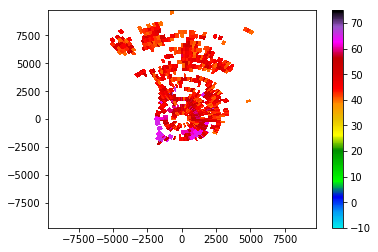

In [24]:
pl.pcolormesh(x[:360, :], y[:360, :], np.ma.masked_where((refl95[:360, :] < 40) | (reflstd[:360, :] >= 10) | (freq[:360, :] <= 95), refl95[:360, :]), cmap='pyart_NWSRef', vmin=-10, vmax=75)
pl.colorbar()
pl.show()

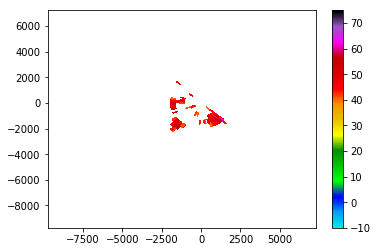

In [25]:
pl.pcolormesh(x[360:, :], y[360:, :], np.ma.masked_where((refl95[360:, :] < 40) | (reflstd[360:, :] >= 10) | (freq[360:, :] <= 95), refl95[360:, :]), cmap='pyart_NWSRef', vmin=-10, vmax=75)
pl.colorbar()
pl.show()

In [26]:
def get_rca(infile, thld=10):
    try:
        r, azi, dbz = read_netcdf(infile)
        rca_lvl0 = np.nanpercentile(np.ma.masked_where((refl95[:360, :] < 40) | (reflstd[:360, :] >= thld) | (freq[:360, :] <= 95), dbz[:360, :36]), 95)
        rca_lvl1 = np.nanpercentile(np.ma.masked_where((refl95[360:, :] < 40) | (reflstd[360:, :] >= thld) | (freq[360:, :] <= 95), dbz[360:, :36]), 95)   
    except Exception:
        return (np.NaN, np.NaN)

    return  rca_lvl0, rca_lvl1

In [28]:
# bag = db.from_sequence(flist)
# bagobj = bag.map(get_rca)
# with ProgressBar():
#     rslt = bagobj.compute()

with Pool(16) as pool:
    rslt = list(tqdm.tqdm_notebook(pool.imap(get_rca, flist), total=len(flist)))

In [31]:
rca_lvl0

array([nan, nan, nan, ..., nan, nan, nan])

In [29]:
rca_lvl0 = np.array(rslt)[:, 0]
rca_lvl1 = np.array(rslt)[:, 1]

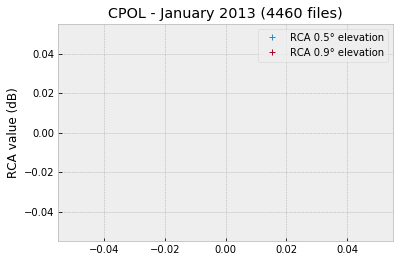

In [30]:
with pl.style.context('bmh'):
    pl.plot(rca_lvl0, '+', label='RCA 0.5° elevation')
    pl.axhline(np.nanmean(np.array(rslt)[:, 0]), color='k', linestyle='dashed')
    pl.plot(rca_lvl1, '+', label='RCA 0.9° elevation')
    pl.title(f'CPOL - January 2013 ({len(rslt)} files)')
    pl.ylabel('RCA value (dB)')
    pl.legend()
    pl.show()
#     pl.savefig('2013_RCA_elev_timeseries.png', dpi=150)

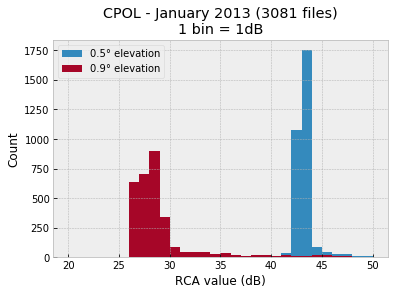

In [62]:
with pl.style.context('bmh'):
    pl.hist(rca_lvl0, range=[20, 50], bins=30, label='0.5° elevation')
    pl.hist(rca_lvl1, range=[20, 50], bins=30, label='0.9° elevation')
    pl.xlabel('RCA value (dB)')
    pl.ylabel('Count')
    pl.title(f'CPOL - January 2013 ({len(rslt)} files)\n1 bin = 1dB')
    pl.legend()
    pl.show()
#     pl.savefig('2013_RCA_elev_histo.png', dpi=150)

In [1]:
# pd.Series(rca_lvl0).dropna().describe()

In [2]:
# pd.Series(rca_lvl1).dropna().describe()